
SETUP



> Importing Librarirs



In [1]:
!pip install keras_tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
import math
import datetime
from datetime import date,datetime
import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import hyperparameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00




> Importing the Dataset



In [2]:
from google.colab import drive
drive.mount
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/')



> Reding the dataset



In [3]:
raw_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/IOT-temp.csv', sep=',', engine='python',encoding='Latin-1')



> Removing non-essential Data



In [4]:
data=raw_data.drop(['id', 'room_id/id'], axis=1)

DATASET CREATION



>Creating a DataFrame with Inside Sensor Readings Only



In [5]:
in_only = data[data.iloc[:,2]=='Out'].index
data_in = data.drop(in_only, axis = 0)
data_in = data_in.drop(['out/in'], axis = 1)
data_in['noted_date'] = pd.to_datetime(data_in['noted_date'], format = '%d-%m-%Y %H:%M')



> Creating a DataFrame with Outside Sensor Readings Only



In [6]:
out_only = data[data.iloc[:,2]=='In'].index
data_out=data.drop(out_only, axis = 0)
data_out = data_out.drop(['out/in'], axis = 1)
data_out['noted_date'] = pd.to_datetime(data_out['noted_date'], format = '%d-%m-%Y %H:%M')



> Plotting the Temperature Readings



<Axes: title={'center': 'Temperature Detected by External IOT Sensor'}, xlabel='Date', ylabel='Temperature'>

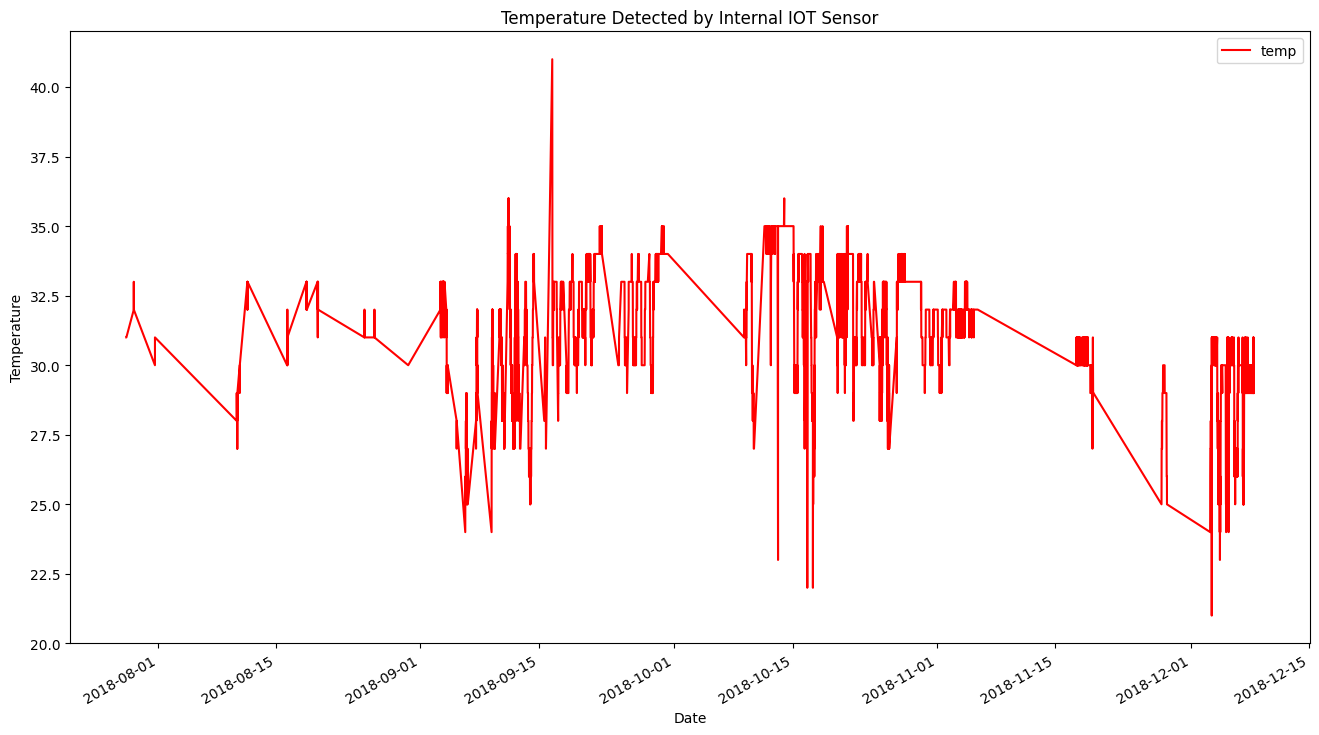

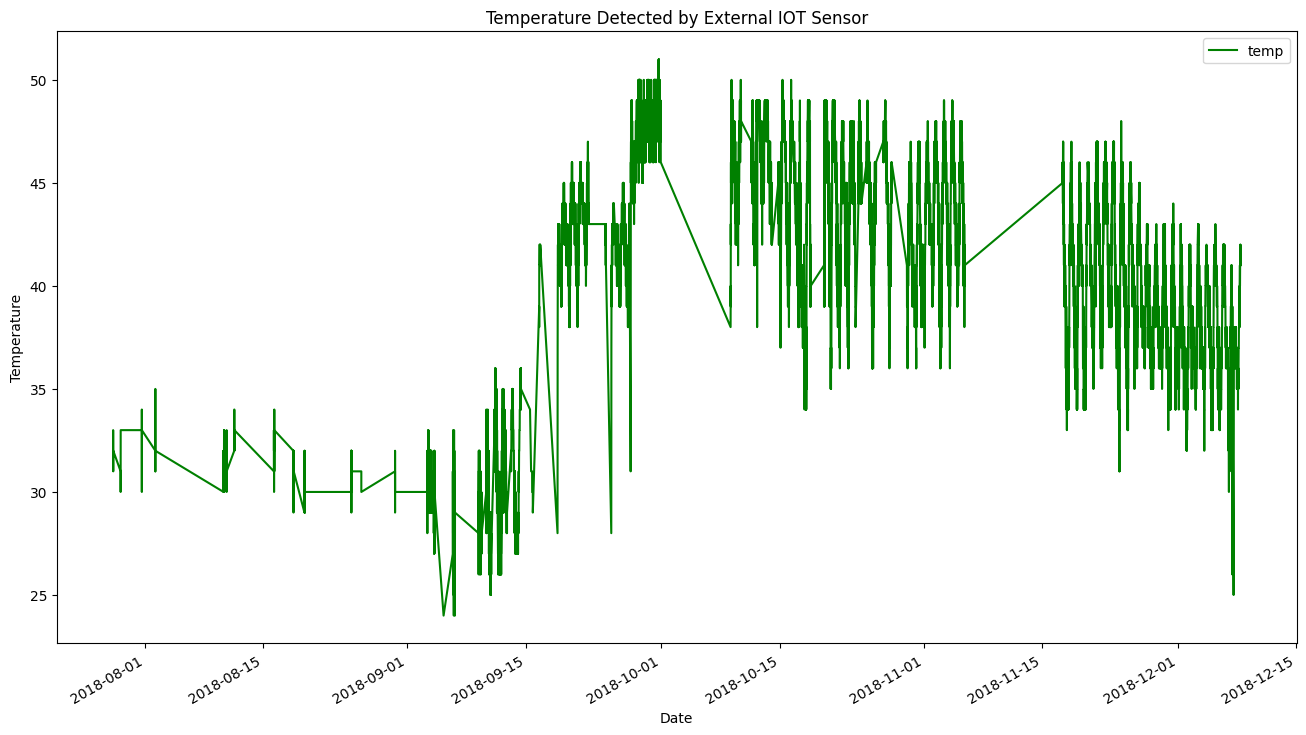

In [7]:
data_in.plot('noted_date','temp', kind = 'line', figsize = (16,9), xlabel = 'Date', ylabel = 'Temperature', title = 'Temperature Detected by Internal IOT Sensor', color = 'Red')
data_out.plot('noted_date','temp', kind = 'line', figsize = (16,9), xlabel = 'Date', ylabel = 'Temperature', title = 'Temperature Detected by External IOT Sensor', color = 'Green')

DATA PREPARATION



> Getting the Temperature Readings



In [8]:
in_temp_raw = np.array(data_in.iloc[:,1 : 2].values, dtype = 'float64')
out_temp_raw = np.array(data_out.iloc[:,1 : 2].values, dtype = 'float64')



> Data Scaling



In [9]:
from sklearn.preprocessing import MinMaxScaler
all_temps = (np.array(data['temp'])).reshape(-1,1)
sc = MinMaxScaler(feature_range = (0,1)).fit(all_temps)
in_temp = sc.transform(in_temp_raw)
out_temp = sc.transform(out_temp_raw)



> Creating a Function for Data Train - Test Split



In [10]:
def IOT_INPUT_DATA (data, test_percent):
    limit = int(((100 - test_percent)/100)*len(data))
    data_train = data[:limit]
    data_test = data[limit : len(data)]
    return data_train, data_test



> Creating a Function to get Number of Look Back Values



In [11]:
def IOT_LOOK_BACK (data_train,units):
    x_train = []
    y_train = []
    for i in range (int(units) , len(data_train)):
        x_train.append(data_train[i- int(units): i, 0])
        y_train.append(data_train[i, 0])
    x_train = np.array(x_train, dtype = 'float64')
    y_train = np.array(y_train, dtype = 'float64')
    x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train



>Implementation



In [12]:
out_train, out_test = IOT_INPUT_DATA (out_temp,  test_percent = 20)
x_train_out, y_train_out = IOT_LOOK_BACK (out_train, units = 5)

in_train, in_test = IOT_INPUT_DATA (in_temp,  test_percent = 20)
x_train_in, y_train_in = IOT_LOOK_BACK (in_train, units = 5)

MODEL IMPLEMENTATION

> Model for Oustside Sensor



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 77)             24332     
                                                                 
 dropout (Dropout)           (None, 5, 77)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 95)             65740     
                                                                 
 dropout_1 (Dropout)         (None, 5, 95)             0         
                                                                 
 lstm_2 (LSTM)               (None, 77)                53284     
                                                                 
 dropout_2 (Dropout)         (None, 77)                0         
                                                                 
 dense (Dense)               (None, 1)                 7

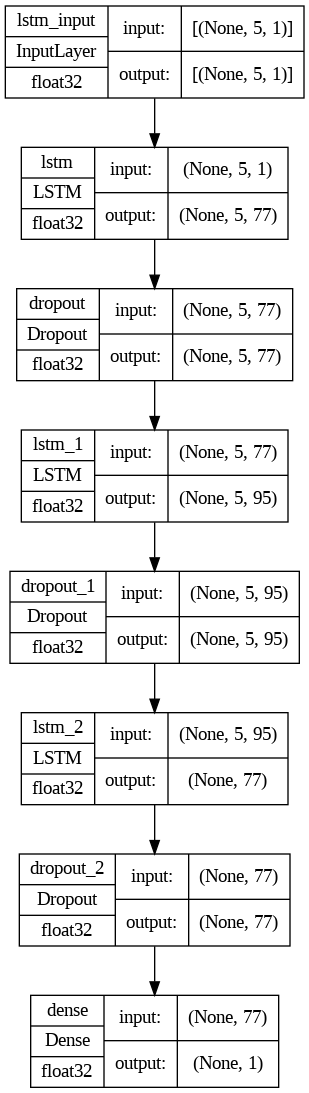

In [13]:
iot_outside = Sequential()
iot_outside.add(LSTM (units = 77 , return_sequences= True, input_shape = (x_train_out.shape[1], 1) ))
iot_outside.add(Dropout (rate = 0.15000000000000002 ))
iot_outside.add(LSTM (units = 95, return_sequences= True ))
iot_outside.add(Dropout (rate = 0.15000000000000002))
iot_outside.add(LSTM (units = 77, return_sequences= False))
iot_outside.add(Dropout (rate = 0.15000000000000002))
iot_outside.add(Dense(1))
iot_outside.compile(optimizer = keras.optimizers.Adam(0.00525), loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(iot_outside.summary())
model_name_out = '/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/IOT_OUTSIDE_TEMP.png'
keras.utils.plot_model(iot_outside, to_file = model_name_out, show_shapes = True, show_dtype = True, show_layer_names = True)



> Model for Inside Sensor



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 77)             24332     
                                                                 
 dropout_3 (Dropout)         (None, 5, 77)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 95)             65740     
                                                                 
 dropout_4 (Dropout)         (None, 5, 95)             0         
                                                                 
 lstm_5 (LSTM)               (None, 77)                53284     
                                                                 
 dropout_5 (Dropout)         (None, 77)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

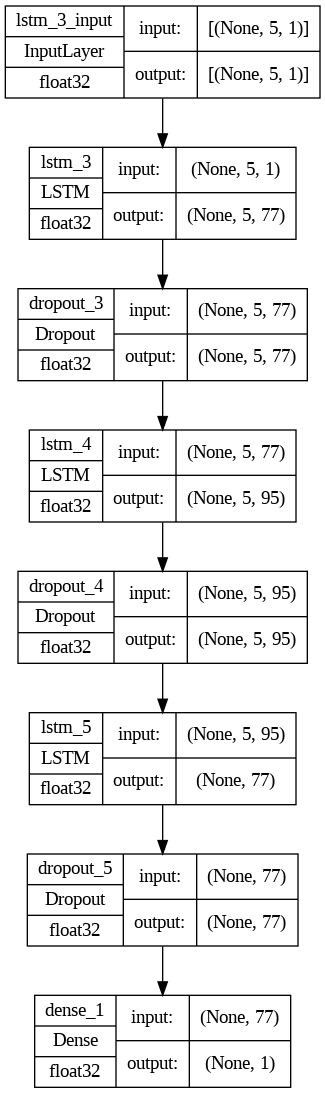

In [14]:
iot_inside = Sequential()
iot_inside.add(LSTM (units = 77 , return_sequences= True, input_shape = (x_train_in.shape[1], 1) ))
iot_inside.add(Dropout (rate = 0.15000000000000002 ))
iot_inside.add(LSTM (units = 95, return_sequences= True ))
iot_inside.add(Dropout (rate = 0.15000000000000002))
iot_inside.add(LSTM (units = 77, return_sequences= False))
iot_inside.add(Dropout (rate = 0.15000000000000002))
iot_inside.add(Dense(1))
iot_inside.compile(optimizer = keras.optimizers.Adam(0.00525), loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(iot_inside.summary())
model_name_in = '/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/IOT_INSIDE_TEMP.png'
keras.utils.plot_model(iot_inside, to_file = model_name_in, show_shapes = True, show_dtype = True, show_layer_names = True)


EVALUATION



> Training



In [15]:
iot_outside.fit(x_train_out, y_train_out, epochs = 100, batch_size = 25 )

Epoch 1/100
2473/2473 [==============================] - 39s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0268
Epoch 2/100
2473/2473 [==============================] - 18s 7ms/step - loss: 7.5737e-04 - mean_absolute_error: 0.0204
Epoch 3/100
2473/2473 [==============================] - 19s 8ms/step - loss: 6.9344e-04 - mean_absolute_error: 0.0195
Epoch 4/100
2473/2473 [==============================] - 18s 7ms/step - loss: 6.3624e-04 - mean_absolute_error: 0.0186
Epoch 5/100
2473/2473 [==============================] - 18s 7ms/step - loss: 5.9704e-04 - mean_absolute_error: 0.0180
Epoch 6/100
2473/2473 [==============================] - 19s 8ms/step - loss: 5.8176e-04 - mean_absolute_error: 0.0177
Epoch 7/100
2473/2473 [==============================] - 19s 8ms/step - loss: 5.5259e-04 - mean_absolute_error: 0.0172
Epoch 8/100
2473/2473 [==============================] - 18s 7ms/step - loss: 5.4227e-04 - mean_absolute_error: 0.0171
Epoch 9/100
2473/2473 [============================

In [16]:
iot_inside.fit(x_train_in, y_train_in, epochs = 100, batch_size = 25 )

Epoch 1/100
651/651 [==============================] - 10s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0270
Epoch 2/100
651/651 [==============================] - 5s 7ms/step - loss: 6.4363e-04 - mean_absolute_error: 0.0180
Epoch 3/100
651/651 [==============================] - 5s 8ms/step - loss: 6.0006e-04 - mean_absolute_error: 0.0172
Epoch 4/100
651/651 [==============================] - 5s 8ms/step - loss: 5.7324e-04 - mean_absolute_error: 0.0169
Epoch 5/100
651/651 [==============================] - 5s 7ms/step - loss: 5.8817e-04 - mean_absolute_error: 0.0169
Epoch 6/100
651/651 [==============================] - 6s 9ms/step - loss: 5.7138e-04 - mean_absolute_error: 0.0167
Epoch 7/100
651/651 [==============================] - 5s 7ms/step - loss: 5.5163e-04 - mean_absolute_error: 0.0164
Epoch 8/100
651/651 [==============================] - 5s 7ms/step - loss: 5.7126e-04 - mean_absolute_error: 0.0167
Epoch 9/100
651/651 [==============================] - 6s 9ms/step - loss: 

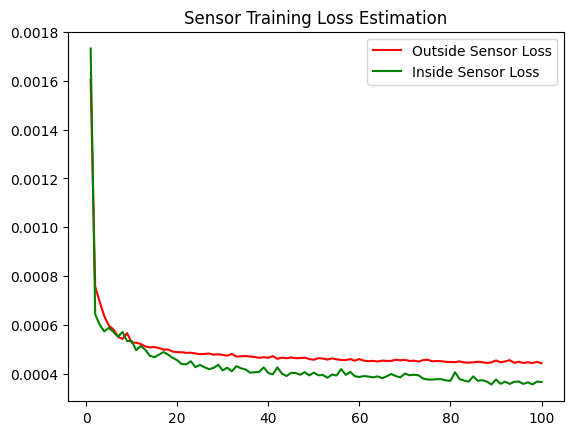

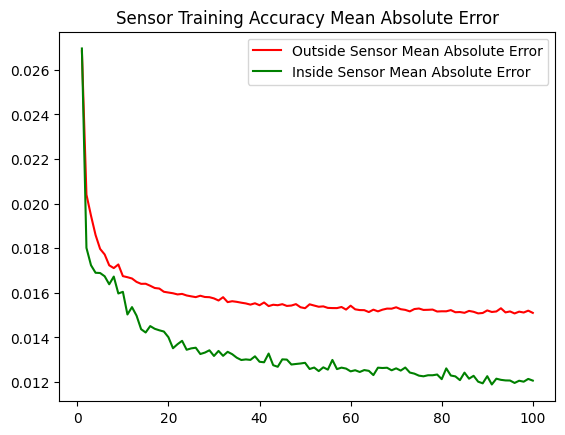

In [17]:
out_abs = iot_outside.history.history['mean_absolute_error']
out_loss = iot_outside.history.history['loss']

in_abs = iot_inside.history.history['mean_absolute_error']
in_loss = iot_inside.history.history['loss']

epochs = range(1,len(in_loss)+1)


plt.plot(epochs,out_loss,'r',label='Outside Sensor Loss')
plt.plot(epochs,in_loss,'g',label='Inside Sensor Loss')
plt.title('Sensor Training Loss Estimation')
plt.legend()
plt.show()

plt.plot(epochs,out_abs,'r',label='Outside Sensor Mean Absolute Error')
plt.plot(epochs,in_abs,'g',label='Inside Sensor Mean Absolute Error')
plt.title('Sensor Training Accuracy Mean Absolute Error')
plt.legend()
plt.show()



> Testing


In [18]:
x_test_out =[]
for i in range( 5, len(out_test)):
    x_test_out.append(out_test[i - 5 :i, 0])
x_test_out=np.array(x_test_out)
x_test_out=np.reshape(x_test_out,(x_test_out.shape[0], x_test_out.shape[1], 1))
predicted_temperature_out_out = iot_outside.predict(x_test_out)
predicted_temperature_out_out = sc.inverse_transform(predicted_temperature_out_out)
predicted_temperature_in_out = iot_outside.predict(x_test_out)
predicted_temperature_in_out = sc.inverse_transform(predicted_temperature_in_out)

x_test_in =[]
for i in range( 5, len(in_test)):
    x_test_in.append(in_test[i - 5 :i, 0])
x_test_in=np.array(x_test_in)
x_test_in=np.reshape(x_test_in,(x_test_in.shape[0], x_test_in.shape[1], 1))
predicted_temperature_out_in =iot_inside.predict(x_test_in)
predicted_temperature_out_in = sc.inverse_transform(predicted_temperature_out_in)
predicted_temperature_in_in = iot_inside.predict(x_test_in)
predicted_temperature_in_in = sc.inverse_transform(predicted_temperature_in_in)

127/127 [==============================] - 0s 3ms/step


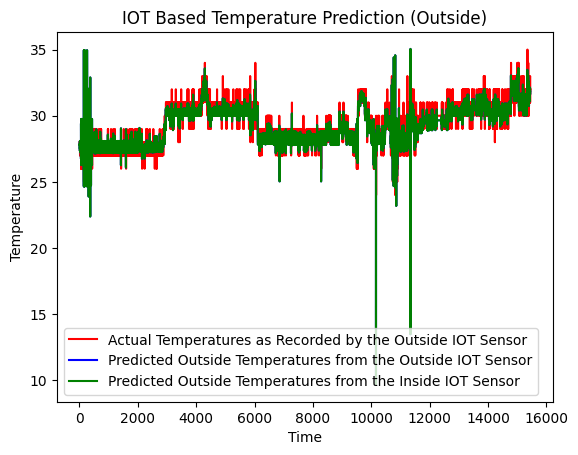

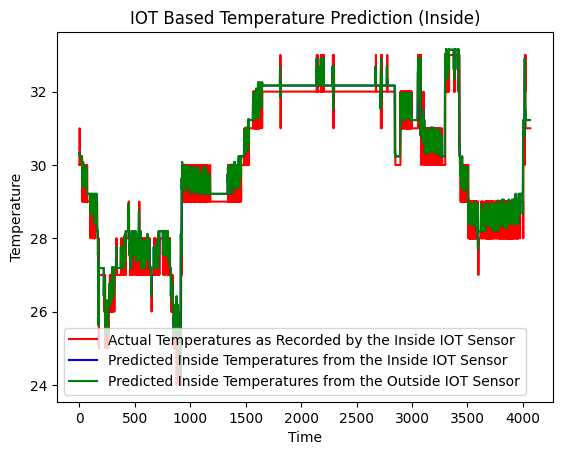

In [42]:
out_test_rescaled = sc.inverse_transform(out_test)
plt.plot(out_test_rescaled, color='r', label = 'Actual Temperatures as Recorded by the Outside IOT Sensor')
plt.plot(predicted_temperature_out_out, color='b', label = 'Predicted Outside Temperatures from the Outside IOT Sensor')
plt.plot(predicted_temperature_in_out, color='g', label = 'Predicted Outside Temperatures from the Inside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Outside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

in_test_rescaled = sc.inverse_transform(in_test)
plt.plot(in_test_rescaled, color='r', label = 'Actual Temperatures as Recorded by the Inside IOT Sensor')
plt.plot(predicted_temperature_in_in, color='b', label = 'Predicted Inside Temperatures from the Inside IOT Sensor')
plt.plot(predicted_temperature_out_in, color='g', label = 'Predicted Inside Temperatures from the Outside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Inside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()



> Test Error Estimation



In [20]:
root_mean_squared_error_out_out=math.sqrt(mean_squared_error(out_test_rescaled[5:], predicted_temperature_out_out))
relative_root_mean_squared_error_out_out = root_mean_squared_error_out_out / (len (out_test_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : '+ str(root_mean_squared_error_out_out))
print('The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : '+ str(relative_root_mean_squared_error_out_out))

root_mean_squared_error_in_out=math.sqrt(mean_squared_error(out_test_rescaled[5:], predicted_temperature_in_out))
relative_root_mean_squared_error_in_out = root_mean_squared_error_in_out / (len (out_test_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : '+ str(root_mean_squared_error_in_out))
print('The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : '+ str(relative_root_mean_squared_error_in_out))

root_mean_squared_error_out_in=math.sqrt(mean_squared_error(in_test_rescaled[5:], predicted_temperature_out_in))
relative_root_mean_squared_error_out_in = root_mean_squared_error_out_in / (len (in_test_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : '+ str(root_mean_squared_error_out_in))
print('The Relative Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : '+ str(relative_root_mean_squared_error_out_in))

root_mean_squared_error_in_in=math.sqrt(mean_squared_error(in_test_rescaled[5:], predicted_temperature_in_in))
relative_root_mean_squared_error_in_in = root_mean_squared_error_in_in / (len (in_test_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Inside Temperature with the Inside Iot Sensor is : '+ str(root_mean_squared_error_in_in))
print('The Relative Root Mean Squared Error when Predidcting the Iniside Temperature with the Inside Iot Sensor is : '+ str(relative_root_mean_squared_error_in_in))

The Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : 0.6714815364550645
The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : 4.346721494400987e-05
The Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : 0.6714815364550645
The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : 4.346721494400987e-05
The Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : 0.4063405462640992
The Relative Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : 9.998537063585118e-05
The Root Mean Squared Error when Predidcting the Inside Temperature with the Inside Iot Sensor is : 0.4063405462640992
The Relative Root Mean Squared Error when Predidcting the Iniside Temperature with the Inside Iot Sensor is : 9.9985370

IMPLEMENTATION ACCROSS THE WHOLE TEMPERATURE RANGE

In [23]:
x_out =[]
for i in range( 5, len(out_temp)):
    x_out.append(out_temp[i - 5 :i, 0])
x_out=np.array(x_out)
x_out=np.reshape(x_out,(x_out.shape[0], x_out.shape[1], 1))
predicted_temperature_out_out_all = iot_outside.predict(x_out)
predicted_temperature_out_out_all = sc.inverse_transform(predicted_temperature_out_out_all)
predicted_temperature_in_out_all = iot_outside.predict(x_out)
predicted_temperature_in_out_all = sc.inverse_transform(predicted_temperature_in_out_all)

x_in =[]
for i in range( 5, len(in_temp)):
    x_in.append(in_temp[i - 5 :i, 0])
x_in=np.array(x_in)
x_in=np.reshape(x_in,(x_in.shape[0], x_in.shape[1], 1))
predicted_temperature_out_in_all =iot_inside.predict(x_in)
predicted_temperature_out_in_all = sc.inverse_transform(predicted_temperature_out_in_all)
predicted_temperature_in_in_all = iot_inside.predict(x_in)
predicted_temperature_in_in_all = sc.inverse_transform(predicted_temperature_in_in_all)

636/636 [==============================] - 2s 3ms/step


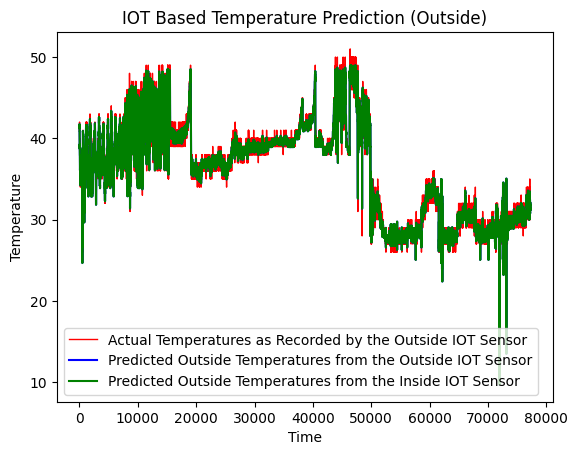

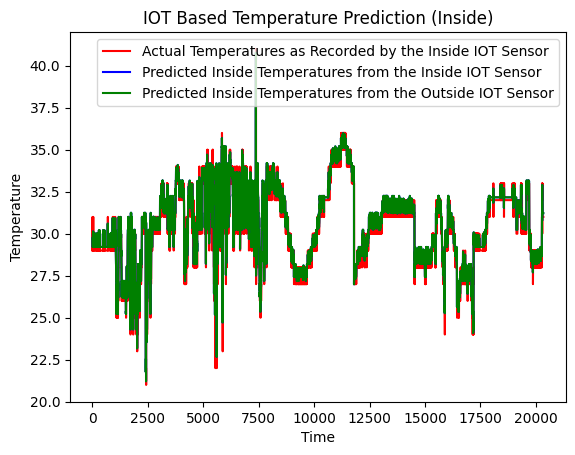

In [48]:
out_temp_rescaled = sc.inverse_transform(out_temp)
plt.plot(out_temp_rescaled, color='r', linewidth = 1, label = 'Actual Temperatures as Recorded by the Outside IOT Sensor')
plt.plot(predicted_temperature_out_out_all, color='b', label = 'Predicted Outside Temperatures from the Outside IOT Sensor')
plt.plot(predicted_temperature_in_out_all, color='g',  label = 'Predicted Outside Temperatures from the Inside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Outside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

in_temp_rescaled = sc.inverse_transform(in_temp)
plt.plot(in_temp_rescaled, color='r', label = 'Actual Temperatures as Recorded by the Inside IOT Sensor')
plt.plot(predicted_temperature_in_in_all, color='b', label = 'Predicted Inside Temperatures from the Inside IOT Sensor')
plt.plot(predicted_temperature_out_in_all, color='g', label = 'Predicted Inside Temperatures from the Outside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Inside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [25]:
root_mean_squared_error_out_out_all =math.sqrt(mean_squared_error(out_temp_rescaled[5:], predicted_temperature_out_out_all))
relative_root_mean_squared_error_out_out_all = root_mean_squared_error_out_out_all / (len (out_temp_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : '+ str(root_mean_squared_error_out_out_all))
print('The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : '+ str(relative_root_mean_squared_error_out_out_all))

root_mean_squared_error_in_out_all =math.sqrt(mean_squared_error(out_temp_rescaled[5:], predicted_temperature_in_out_all))
relative_root_mean_squared_error_in_out_all = root_mean_squared_error_in_out_all / (len (out_temp_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : '+ str(root_mean_squared_error_in_out_all))
print('The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : '+ str(relative_root_mean_squared_error_in_out_all))

root_mean_squared_error_out_in_all =math.sqrt(mean_squared_error(in_temp_rescaled[5:], predicted_temperature_out_in_all))
relative_root_mean_squared_error_out_in_all = root_mean_squared_error_out_in_all / (len (in_temp_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : '+ str(root_mean_squared_error_out_in_all))
print('The Relative Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : '+ str(relative_root_mean_squared_error_out_in_all))

root_mean_squared_error_in_in_all =math.sqrt(mean_squared_error(in_temp_rescaled[5:], predicted_temperature_in_in_all))
relative_root_mean_squared_error_in_in_all = root_mean_squared_error_in_in_all / (len (in_temp_rescaled)-5)
print('The Root Mean Squared Error when Predidcting the Inside Temperature with the Inside Iot Sensor is : '+ str(root_mean_squared_error_in_in_all))
print('The Relative Root Mean Squared Error when Predidcting the Iniside Temperature with the Inside Iot Sensor is : '+ str(relative_root_mean_squared_error_in_in_all))

The Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : 0.5868913328333651
The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Outside Iot Sensor is : 7.596708771271683e-06
The Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : 0.5868913328333651
The Relative Root Mean Squared Error when Predidcting the Outiside Temperature with the Inside Iot Sensor is : 7.596708771271683e-06
The Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : 0.52932116027369
The Relative Root Mean Squared Error when Predidcting the Inside Temperature with the Outside Iot Sensor is : 2.602365586399656e-05
The Root Mean Squared Error when Predidcting the Inside Temperature with the Inside Iot Sensor is : 0.52932116027369
The Relative Root Mean Squared Error when Predidcting the Iniside Temperature with the Inside Iot Sensor is : 2.60236558639

SAVING THE MODELS

In [26]:
iot_outside.save("/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/outside_iot_sensor_model.h5")
iot_inside.save("/content/drive/MyDrive/Colab Notebooks/Projects for Show/IoT Temperature Prediction/inside_iot_sensor_model.h5")